In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import git
import os
from scipy import signal

# Get git repository root
repo = git.Repo(".", search_parent_directories = True)
# Update notebook working dir to repository root
os.chdir(repo.working_tree_dir)

# Load frequently used methods
with open("notebooks/methods.py", "r") as file:
    exec(file.read())

with open("python/movement_methods.py", "r") as file:
    exec(file.read())

with open("python/rest_methods.py", "r") as file:
    exec(file.read())

with open("python/plot_all_events.py", "r") as file:
    exec(file.read())

# Rest detection using low-pass filtered data

In [2]:
samples = pd.read_csv("sample_sheet.csv")
sample = samples.iloc[1]
sample

SID              W1_C2
AnimalID            W1
CellName            C2
Region          S1_L23
Date        2019 12 09
Depth       265.898093
Count              270
Location         W1/C2
Cortex              S1
Layer              L23
Name: 1, dtype: object

In [3]:
data = pd.read_pickle(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/emg/filter.pkl")
channels = data.ch_names

## Rest episodes in a single trial

In [4]:
sample_data = data.get_data()
channel_data = sample_data[1]
time = data.times

In [5]:
butter_filter = signal.butter(
    N = 20,
    Wn = [ 20 ],
    btype = "lowpass",
    output = "sos",
    fs = 20_000
)

filtered = signal.sosfiltfilt(butter_filter, np.abs(channel_data))

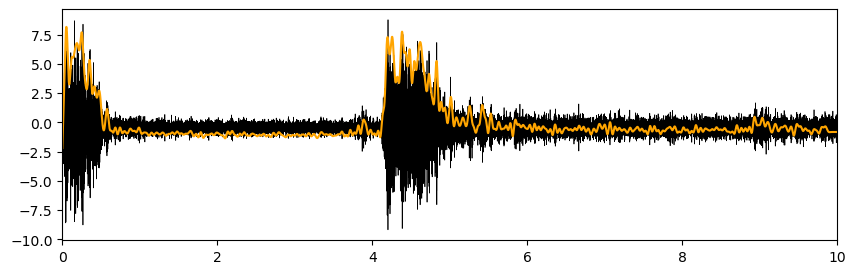

In [6]:
plt.figure(figsize = (10, 3))
plt.plot(time, (channel_data - np.mean(np.abs(channel_data))), linewidth = 0.5, c = "black")
plt.plot(time, (filtered - np.mean(filtered)) / 0.25, c = "orange")
plt.xlim(0, 10)
plt.show()

In [7]:
def filter_emg(data, low_freq = 100, sfreq = 20_000):
    from scipy import signal
    import numpy as np

    butter_filter = signal.butter(
        N = 20,
        Wn = [ low_freq ],
        btype = "lowpass",
        output = "sos",
        fs = sfreq
    )

    return signal.sosfiltfilt(butter_filter, np.abs(data))

In [8]:
filtered_data = []
for channel in sample_data:
    filtered_data.append(filter_emg(channel, low_freq = 20, sfreq = data.info["sfreq"]))
filtered_data = np.array(filtered_data)

In [9]:
threshold = np.percentile(np.abs(filtered_data), 80)

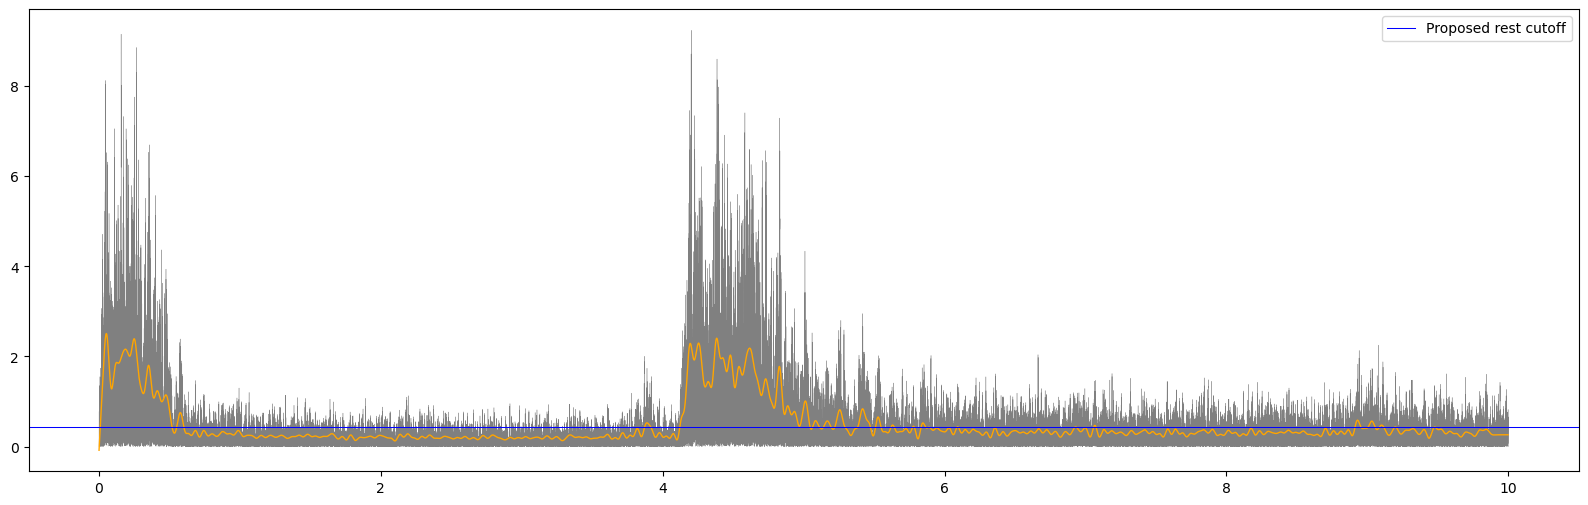

In [10]:
plt.figure(figsize = (20, 6))
plt.plot(time, np.abs(channel_data), c = "gray", linewidth = 0.25)
plt.plot(time, filtered, c = "orange", linewidth = 1)
plt.axhline(y = threshold, color = "blue", linestyle = "-", linewidth = 0.75, label = "Proposed rest cutoff")
plt.legend()
plt.show()

In [11]:
signal_over_threshold = np.abs(filtered) > threshold
change_indices = np.where(np.diff(signal_over_threshold))[0]

movement_data = pd.DataFrame({
    "EventStart": np.insert(change_indices + 1, 0, 0),
    "EventEnd": np.append(change_indices + 1, len(signal_over_threshold))
})

movement_data["Movement"] = signal_over_threshold[movement_data["EventStart"]]
movement_data = movement_data[movement_data["Movement"] == False]
movement_data["EventLength"] = list(movement_data["EventEnd"] - movement_data["EventStart"])

movement_data = merge_close_events(movement_data, min_break = 0.025 * 20_000)

movement_data = movement_data[movement_data["EventLength"] >= 2000]

movement_data["Start"] = movement_data["EventStart"] / data.info["sfreq"]
movement_data["End"] = movement_data["EventEnd"] / data.info["sfreq"]
movement_data["Length"] = movement_data["EventLength"] / data.info["sfreq"]

In [12]:
movement_data

,EventStart,EventEnd,Movement,EventLength,Start,End,Length
2,12032,77443,False,65411,0.60160,3.87215,3.27055
3,78298,82433,False,4135,3.91490,4.12165,0.20675
10,112843,115503,False,2660,5.64215,5.77515,0.13300
12,117290,121832,False,4542,5.86450,6.09160,0.22710
13,121892,141188,False,19296,6.09460,7.05940,0.96480
14,141491,178276,False,36785,7.07455,8.91380,1.83925
17,182323,200001,False,17678,9.11615,10.00005,0.88390


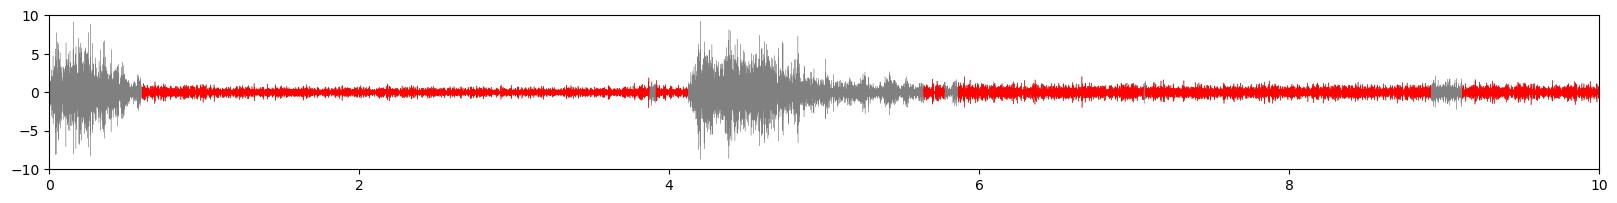

In [13]:
plt.figure(figsize = (20, 2))

x = data.times
y = channel_data

plt.plot(x, y, c = "gray", linewidth = 0.25)

for i, episode in movement_data.iterrows():
    x = data.times[episode["EventStart"]:episode["EventEnd"]]
    y = channel_data[episode["EventStart"]:episode["EventEnd"]]

    plt.plot(x, y, c = "red", linewidth = 0.25)

plt.ylim(-10, 10)
plt.xlim(0, 10)
plt.show()

## Rest in all trials

In [14]:
def detect_rest_episodes(signal, threshold, sfreq, min_break):
    signal_over_threshold = np.abs(signal) > threshold
    change_indices = np.where(np.diff(signal_over_threshold))[0]
    
    movement_data = pd.DataFrame({
        "EventStart": np.insert(change_indices + 1, 0, 0),
        "EventEnd": np.append(change_indices + 1, len(signal_over_threshold))
    })
    
    movement_data["Movement"] = signal_over_threshold[movement_data["EventStart"]]
    movement_data = movement_data[movement_data["Movement"] == False]
    movement_data["EventLength"] = list(movement_data["EventEnd"] - movement_data["EventStart"])
    
    movement_data = merge_close_events(movement_data, min_break = min_break)
    
    movement_data["Start"] = movement_data["EventStart"] / sfreq
    movement_data["End"] = movement_data["EventEnd"] / sfreq
    movement_data["Length"] = movement_data["EventLength"] / sfreq
    
    return movement_data

In [15]:
sample_data = data.get_data()

# Apply low frequency filter on all channels
filtered_data = []
for channel in sample_data:
    filtered_data.append(filter_emg(channel, low_freq = 20, sfreq = data.info["sfreq"]))
filtered_data = np.array(filtered_data)

threshold = np.percentile(np.abs(filtered_data), 80)

episodes = []

for i, _ in enumerate(data.ch_names):
    signal = filtered_data[i]

    ch_episodes = detect_rest_episodes(signal = signal, threshold = threshold, sfreq = data.info["sfreq"], min_break = 500)
    ch_episodes["Channel"] = i
    episodes.append(ch_episodes)

episodes = pd.concat(episodes)
episodes = episodes.reset_index(drop = True)

episodes = episodes[ episodes["EventLength"] > 2500 ]

In [16]:
movement = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/movement_episodes.csv")

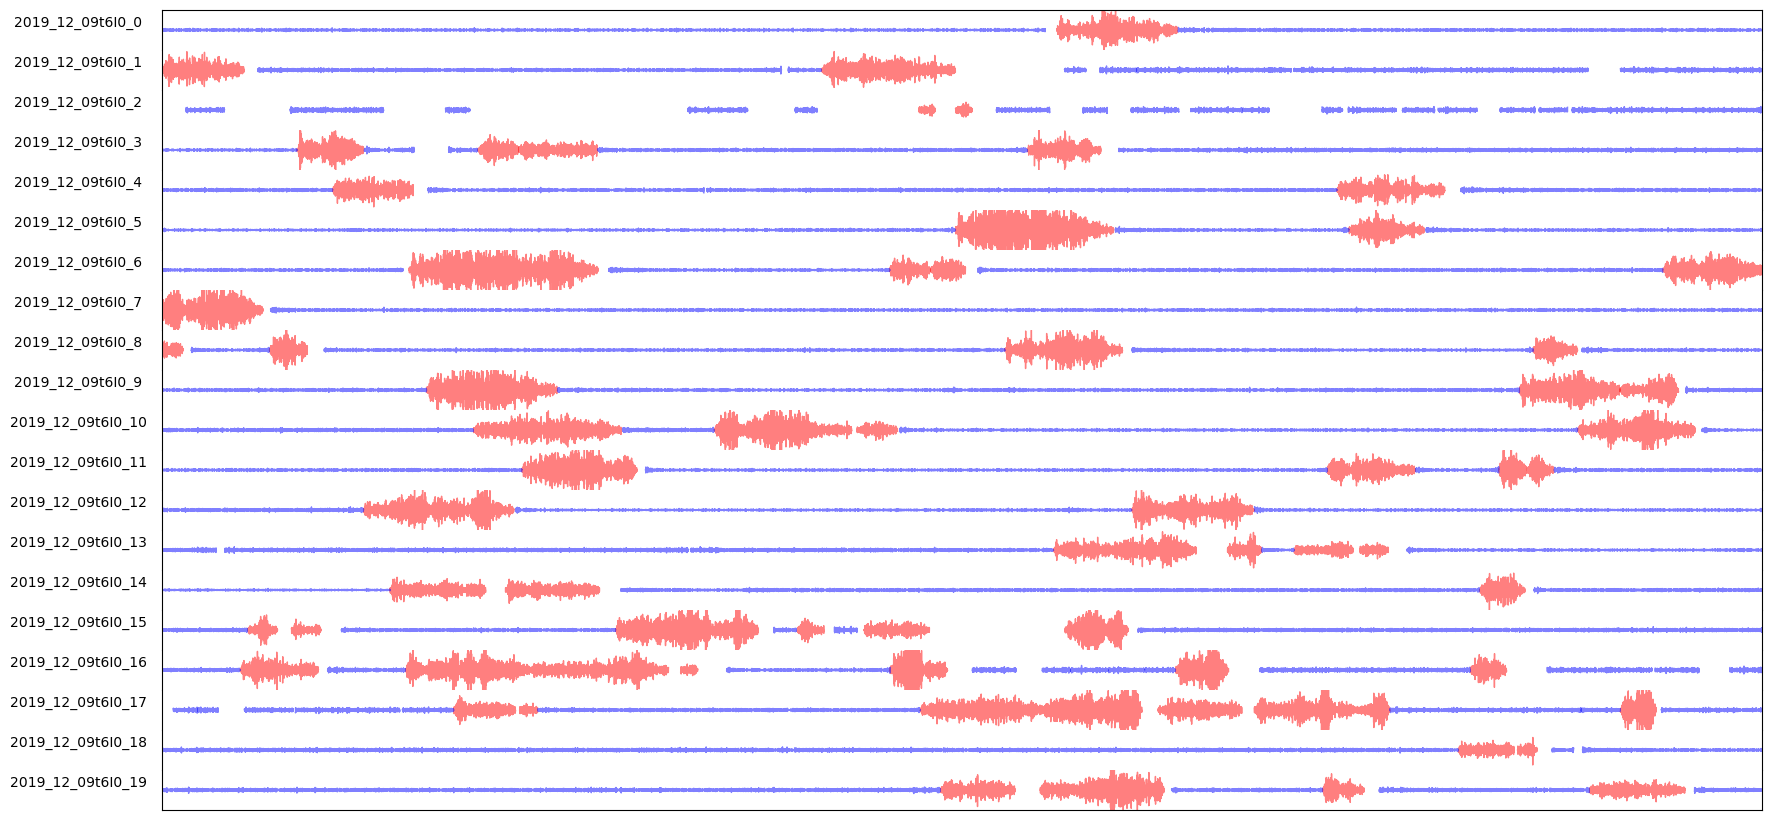

In [17]:
plot_all_events(data, channels = data.ch_names, movement = movement, no_movement = episodes, limit = [-10, 10], show_full = False, alpha = 0.5)